# Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_theme(style="white", context="notebook", palette="deep")
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, KFold

# Functions

In [4]:
def random_SCV(pipe = [],
               grid_param = [],
               n_iter = 10,
               cv = 5,
               scoring = "neg_mean_squared_error",
               rnd_state = 42,
               file_name = "",
               training = []):
    rnd_search = RandomizedSearchCV(pipe, param_distributions=grid_param, n_iter=n_iter, cv=cv, scoring=scoring, verbose=100000)
    rnd_search.fit(training[0], training[1])
    wr_pkl_file(file_name, rnd_search, False)

def grid_SCV(pipe = [], grid_param = [], cv = 5, scoring = "neg_mean_squared_error", file_name = "", training = []):
    rnd_search = GridSearchCV(pipe, grid_param, cv=cv, scoring=scoring, verbose=100)
    rnd_search.fit(training[0], training[1])
    wr_pkl_file(file_name, rnd_search, False)

def wr_pkl_file(file_name = "", content = "", read = False):
    if file_name:
        path_ = "./param_tuning/" + file_name
        if read:
            return joblib.load(path_)
        else:
            if content:
                joblib.dump(content, path_)

def print_results(labels = [], est = [], plt_num = 50, testing = []):
    col = 1
    plt.rcParams['figure.figsize'] = (30,15)
    for name, clf in zip(labels,est):
        print(name)

        df_labels_prediction = clf.predict(testing[0])

        print("R-Squared: {:.3f}".format(r2_score(np.exp(testing[1]), np.exp(df_labels_prediction))))
        mse = mean_squared_error(np.exp(testing[1]), np.exp(df_labels_prediction))
        mae = mean_absolute_error(np.exp(testing[1]), np.exp(df_labels_prediction))

        rmse = np.sqrt(mse)
        print("Root Mean Suqre Error: {:,.3f}".format(rmse))
        print("Mean Absolute Error: {:,.3f}".format(mae))
        print()

        plt.subplot(3,1,col)

        plt.title(name.replace(":", ""), fontsize= 18)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.plot(range(plt_num), np.exp(df_labels_prediction)[:plt_num], "*-", label="model prediction")
        plt.plot(range(plt_num), np.exp(testing[1])[:plt_num], "o--", label="true value")
        plt.legend()
        col += 1

def validation(models = [], estimators = [], training = [], cv = 5, train_score = False):
    if len(models) != len(estimators):
        print("Error: Model Names And Estimator Must Have The Same Length")
        return
    
    for model, estimator in zip(models, estimators):
        scores = cross_validate(estimator, training[0], training[1], cv=cv, scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"), return_train_score=train_score)
    
        print(model)
        print("R-Squared: {:,.3f}".format(np.mean(scores["test_r2"])))
        print("Root Mean Squared Error: {:,.3f}".format(np.mean(np.sqrt(-scores["test_neg_mean_squared_error"]))))
        print("Mean Absolute Error: {:,.3f}".format(np.mean(-scores["test_neg_mean_absolute_error"])))
        print()

# Data Cleaning

In [11]:
url = "https://drive.google.com/file/d/1Q3_zadThHAeiEJNU-ieZJy3oIFs5QXdp/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]

df  = pd.read_csv(path)

df.replace(" -  ", np.nan, inplace=True)

df.drop(["Agricultural Household indicator", "Household Head Gender", "Household Head Marital Status",
         "Household Head Highest Grade Completed", "Education Rank", "Household Head Occupation",
         "Household Head Class of Worker", "Type of Household", "Total Number of Family members",
         "Members with age less than 5 year old", "Members with age 5 - 17 years old", "House Floor Area",
         "House Age", "Number of bedrooms", "Tenure Status", "Number of Television", "Number of CD/VCD/DVD",
         "Number of Component/Stereo set", "Number of Refrigerator/Freezer", "Number of Washing Machine",
         "Number of Airconditioner", "Number of Car, Jeep, Van", "Number of Landline/wireless telephones",
         "Number of Cellular phone", "Number of Personal Computer", "Number of Stove with Oven/Gas Range",
         "Number of Motorized Banca", "Number of Motorcycle/Tricycle"], axis=1, inplace=True)

floats = ["Total Household Income", "Staple Food Expenditure", "Meat Expenditure", "Seafood Expenditure",
          "Leisure Expenditure", "Alcohol Expenditure ", "Tobacco Expenditure", "Medical Expenditure",
          "Transportation Expenditure", "Communication Expenditure", "Crop Farming Expenditure",
          "Household Head Age", "Occupation group", "Total number of family members employed", "Electricity"]

for col in floats:
    df[col] = pd.to_numeric(df[col], errors="coerce")

categorical_columns = ["Region", "Source of Income", "Household Head Job Indicator", "Main Source of Water Supply"]

for col in categorical_columns:
    df[col] = df[col].str.strip()

df = df[df['Total Household Income'] > 0]
df = df[df['Total number of family members employed'] > 0]

print("Shape before removing duplicates:", df.shape)
df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", df.shape)

df.dropna(inplace=True)

print(df.head())

label_encoder = lambda x: {uniq: i for i, uniq in enumerate(df[x].unique().tolist())}

Shape before removing duplicates: (30050, 22)
Shape after removing duplicates: (30050, 22)
   Total Household Income Region  Staple Food Expenditure Source of Income  \
0                    9370    CAR                     1736             Wage   
1                    3540    CAR                      718             Wage   
2                    1478    CAR                     1281             Wage   
3                    2199    CAR                     1273             Wage   
4                    4732    CAR                     1386             Wage   

   Meat Expenditure  Seafood Expenditure  Leisure Expenditure  \
0               441                  300                  129   
1               311                  198                   27   
2               139                   46                    9   
3               195                  193                    9   
4               328                  202                   18   

   Alcohol Expenditure   Tobacco Expenditure  Med

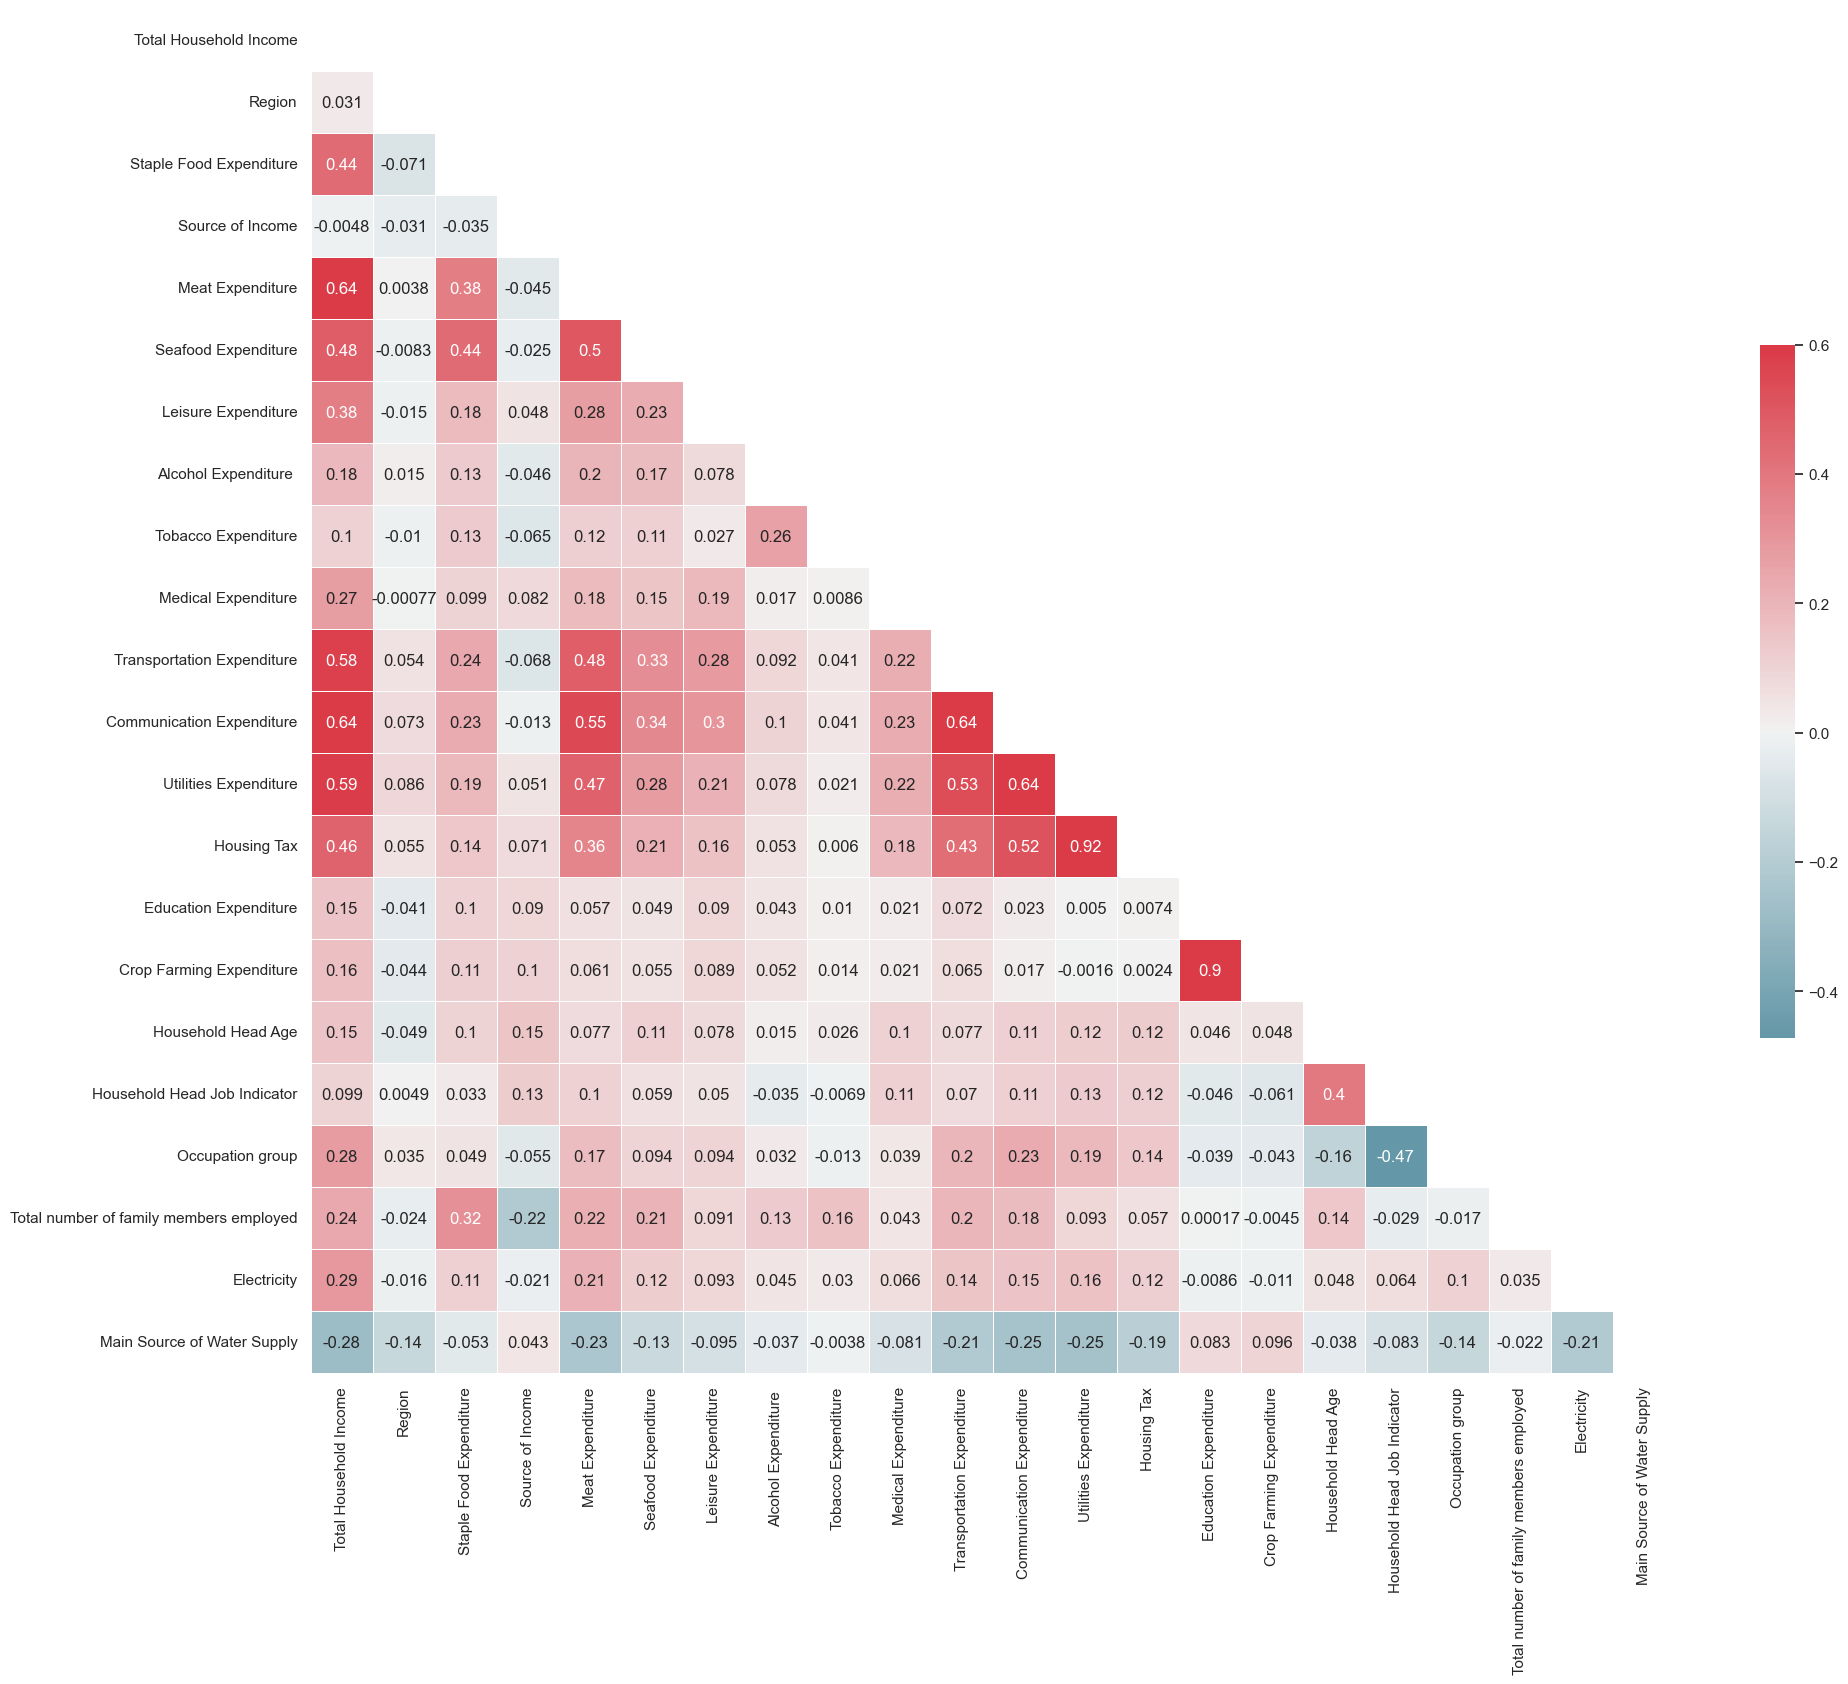

In [12]:
df_copy = df.copy()

df_copy['Total Household Income'] = np.log(df_copy['Total Household Income'])

df_copy['Region'] = df_copy['Region'].map(label_encoder("Region"))
df_copy['Source of Income'] = df_copy['Source of Income'].map(label_encoder("Source of Income"))
df_copy['Household Head Job Indicator'] = df_copy['Household Head Job Indicator'].map(label_encoder("Household Head Job Indicator"))
df_copy['Main Source of Water Supply'] = df_copy['Main Source of Water Supply'].map(label_encoder("Main Source of Water Supply"))

sns.set_theme(style="white")

corr = df_copy.corr(method="pearson")

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(22,18))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

del df_copy


# Handling Outliers

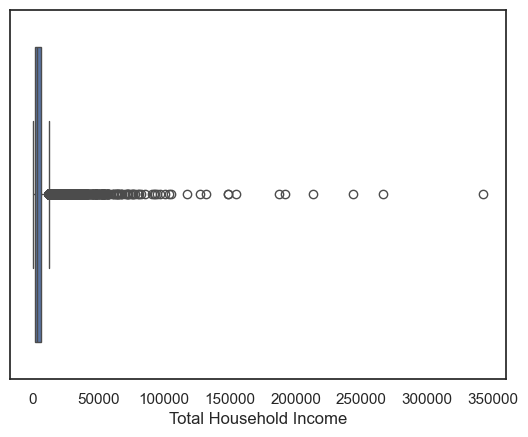

In [13]:
df_copy = df.copy()
sns.boxplot(x=df_copy["Total Household Income"])
test = df_copy[df_copy["Total Household Income"] > df_copy["Total Household Income"].quantile(0.90)]

<Axes: >

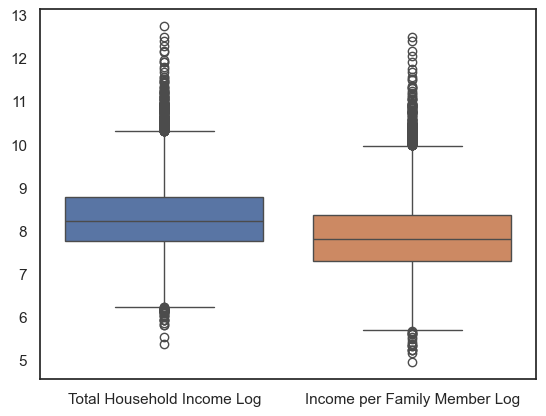

In [16]:
df_copy['Income per Family Member Log'] = np.log(df_copy['Total Household Income'] / df_copy['Total number of family members employed'])
df_copy['Total Household Income Log'] = np.log(df_copy['Total Household Income'])
sns.boxplot(data=df_copy[['Total Household Income Log', 'Income per Family Member Log']])

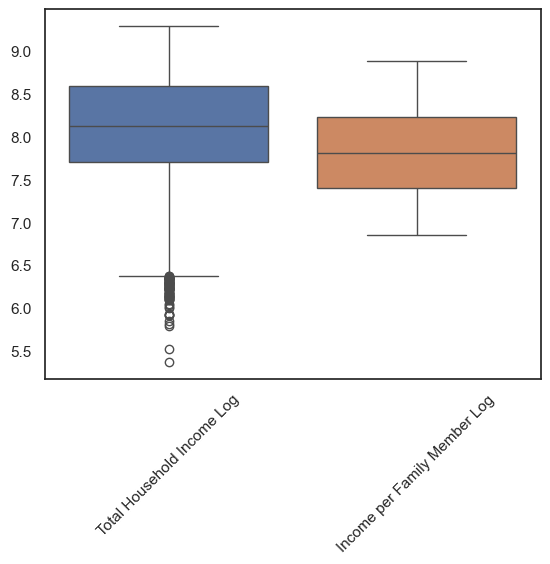

In [17]:
income_log_threshold_low = df_copy["Total Household Income Log"].quantile(0.10)
income_log_threshold_high = df_copy["Total Household Income Log"].quantile(0.90)

income_per_member_log_threshold_low = df_copy["Income per Family Member Log"].quantile(0.10)
income_per_member_log_threshold_high = df_copy["Income per Family Member Log"].quantile(0.90)

a = df_copy[df_copy['Total Household Income Log'] < income_log_threshold_high]
b = df_copy[(df_copy['Income per Family Member Log'] > income_per_member_log_threshold_low) & (df_copy['Income per Family Member Log'] < income_per_member_log_threshold_high)]
ax = sns.boxplot(data=[a['Total Household Income Log'], b['Income per Family Member Log']])
ax.set_xticklabels(['Total Household Income Log', 'Income per Family Member Log'], rotation=45)
del a,b

In [18]:
print(len(df_copy))
print(len(df_copy[(df_copy["Income per Family Member Log"] < income_per_member_log_threshold_high) | (df_copy["Income per Family Member Log"] > income_per_member_log_threshold_low)]))
print(len(df_copy[df_copy["Total Household Income Log"] > income_log_threshold_low]))
print(len(test))

30050
30050
27041
3005


# Machine Learning

## Preprocessing

In [79]:
def label_encode(column = ""):
    if column:
        df[column] = df[column].map(label_encoder(column))

label_encode("Region")
label_encode("Source of Income")
label_encode("Household Head Job Indicator")
label_encode("Main Source of Water Supply")

lr_df = df.copy()

df["Total Household Income Log"] = np.log(df["Total Household Income"])

modified_df = df[[
    "Region",
    "Staple Food Expenditure",
    "Source of Income",
    "Meat Expenditure",
    "Seafood Expenditure",
    "Leisure Expenditure",
    "Alcohol Expenditure ",
    "Tobacco Expenditure",
    "Medical Expenditure",
    "Transportation Expenditure",
    "Communication Expenditure",
    "Utilities Expenditure",
    "Housing Tax",
    "Education Expenditure",
    "Crop Farming Expenditure",
    "Household Head Age",
    "Household Head Job Indicator",
    "Occupation group",
    "Total number of family members employed",
    "Electricity",
    "Main Source of Water Supply"
]]

y = df["Total Household Income Log"]

tr_x_train, tr_x_test, tr_y_train, tr_y_test = train_test_split(modified_df, y, test_size=0.2, random_state=42)

lr_df["Income per Family Member"] = lr_df["Total Household Income"] / lr_df["Total number of family members employed"]
lr_df["Income per Family Member Log"] = np.log(lr_df["Income per Family Member"])

lower_threshold = lr_df["Income per Family Member Log"].quantile(0.01)
upper_threshold = lr_df["Income per Family Member Log"].quantile(0.99)

lr_df = lr_df[(lr_df["Income per Family Member Log"] > lower_threshold) & (lr_df["Income per Family Member Log"] < upper_threshold)]

lr_modified = lr_df[[
    "Region",
    "Staple Food Expenditure",
    "Source of Income",
    "Meat Expenditure",
    "Seafood Expenditure",
    "Leisure Expenditure",
    "Alcohol Expenditure ",
    "Tobacco Expenditure",
    "Medical Expenditure",
    "Transportation Expenditure",
    "Communication Expenditure",
    "Utilities Expenditure",
    "Housing Tax",
    "Education Expenditure",
    "Crop Farming Expenditure",
    "Household Head Age",
    "Household Head Job Indicator",
    "Occupation group",
    "Total number of family members employed",
    "Electricity",
    "Main Source of Water Supply",
    "Income per Family Member Log",
    "Total Household Income Log"
]]

train_set, test_set = train_test_split(lr_modified, test_size=0.4, random_state=60)

lr_y_train_ppu = train_set["Income per Family Member Log"].copy()
lr_y_train_ru = train_set["Total number of family members employed"].copy() # For cross-validation
lr_y_train = train_set["Total Household Income Log"].copy()        # For cross-validation
lr_x_train_ppu = train_set.drop(["Total Household Income Log", "Income per Family Member Log", "Total number of family members employed"], axis=1)

# Split data and target in test set
lr_y_test_ppu = test_set["Income per Family Member Log"].copy()
lr_y_test = test_set["Total Household Income Log"].copy()
lr_y_test_ru = test_set["Total number of family members employed"]
lr_x_test_ppu = test_set.drop(["Total Household Income Log", "Income per Family Member Log", "Total number of family members employed"], axis=1)

# Dummy Regressor

In [80]:
## Trees
print("Trees df")

# Initialize Dummy estimator 
dummy_regr = DummyRegressor(strategy="median")

# Train estimator
dummy_regr.fit(tr_x_train, tr_y_train)

# Predict 
preds = np.exp(dummy_regr.predict(tr_x_test))


# Calculate RMSE
mse = mean_squared_error(np.exp(tr_y_test), preds)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(np.exp(tr_y_test), preds)

# Print results
print("R-Squared: {:,.3f}".format(r2_score(np.exp(tr_y_test), preds)))
print("Root Mean Square Error: {:,.3f}".format(rmse))
print("Mean Absolute Error: {:,.3f}".format(mae))
print()


## Linear Regression
print("Linear Regression df")

# Initialize Dummy estimator 
lr_dummy_regr = DummyRegressor(strategy="median")

# Train estimator
lr_dummy_regr.fit(lr_x_train_ppu, lr_y_train_ppu)

# Predict 
lr_preds = np.exp(lr_dummy_regr.predict(lr_x_test_ppu))

# Calculate RMSE
mse = mean_squared_error(np.exp(lr_y_test_ppu) * lr_y_test_ru, lr_preds * lr_y_test_ru)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(np.exp(lr_y_test_ppu)* lr_y_test_ru, lr_preds * lr_y_test_ru)

# Print results
print("R-Squared: {:,.3f}".format(r2_score(np.exp(lr_y_test_ppu) * lr_y_test_ru, lr_preds * lr_y_test_ru)))
print("Root Mean Square Error: {:,.3f}".format(rmse))
print("Mean Absolute Error: {:,.3f}".format(mae))
print()

Trees df
R-Squared: -0.062
Root Mean Square Error: 7,415.297
Mean Absolute Error: 3,168.942

Linear Regression df
R-Squared: -0.030
Root Mean Square Error: 4,546.771
Mean Absolute Error: 2,951.751



## Pipeline

In [81]:
numeric_features = ["Staple Food Expenditure", "Meat Expenditure", "Seafood Expenditure",
                    "Leisure Expenditure", "Alcohol Expenditure ", "Tobacco Expenditure",
                    "Medical Expenditure", "Transportation Expenditure", "Communication Expenditure",
                    "Communication Expenditure", "Utilities Expenditure", "Housing Tax",
                    "Education Expenditure", "Crop Farming Expenditure", "Household Head Age",
                    "Occupation group", "Electricity"]
categorical_features = ["Region", "Source of Income", "Household Head Job Indicator", "Main Source of Water Supply"]

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])

ohe_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', numeric_transformer, numeric_features),
        ('ohe', ohe_transformer, categorical_features),
    ])

X = df[numeric_features + categorical_features]
y = df['Total Household Income Log']

## ML Estimators

In [82]:
# Linear regression Estimator
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])

# Decision Tree Regressor
dtr = Pipeline(steps=[
                      ('dtr', DecisionTreeRegressor())])

# Extra Tree Regressor
etr = Pipeline(steps=[
                      ('etr', BaggingRegressor(ExtraTreeRegressor(random_state=42),
                                                        random_state = 42))])
# Random Forest Regressor
rfrr = Pipeline(steps=[
                      ('rfregression', RandomForestRegressor(random_state = 42, 
                                                             n_jobs= -1, 
                                                             n_estimators = 50, 
                                                             min_samples_leaf = 5))])

# Cross Validation

In [83]:
# Check for infinite values
print("Checking for infinite values in lr_x_train_ppu:")
print(np.isinf(lr_x_train_ppu).sum())

print("Checking for infinite values in lr_y_train_ppu:")
print(np.isinf(lr_y_train_ppu).sum())

print("Checking for infinite values in lr_y_train_ru:")
print(np.isinf(lr_y_train_ru).sum())

# Replace infinite values with NaN and then fill NaN values
lr_x_train_ppu.replace([np.inf, -np.inf], np.nan, inplace=True)
lr_y_train_ppu.replace([np.inf, -np.inf], np.nan, inplace=True)
lr_y_train_ru.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the mean of the column
lr_x_train_ppu.fillna(lr_x_train_ppu.mean(), inplace=True)
lr_y_train_ppu.fillna(lr_y_train_ppu.mean(), inplace=True)
lr_y_train_ru.fillna(lr_y_train_ru.mean(), inplace=True)

Checking for infinite values in lr_x_train_ppu:
Region                          0
Staple Food Expenditure         0
Source of Income                0
Meat Expenditure                0
Seafood Expenditure             0
Leisure Expenditure             0
Alcohol Expenditure             0
Tobacco Expenditure             0
Medical Expenditure             0
Transportation Expenditure      0
Communication Expenditure       0
Utilities Expenditure           0
Housing Tax                     0
Education Expenditure           0
Crop Farming Expenditure        0
Household Head Age              0
Household Head Job Indicator    0
Occupation group                0
Electricity                     0
Main Source of Water Supply     0
dtype: int64
Checking for infinite values in lr_y_train_ppu:
0
Checking for infinite values in lr_y_train_ru:
0


## Linear Regression

In [84]:
# initialize the model
kf = KFold(n_splits=10, random_state = 42, shuffle = True)

# make a list to store our RMSE 
lr_RMSEs, lr_R2, lr_MAE = [], [], []

# loop over the k folds
for train_index, validate_index in kf.split(lr_x_train_ppu):
    
    # train the model using the training set
    lr.fit(lr_x_train_ppu.iloc[train_index,], lr_y_train_ppu.iloc[train_index,])
    
    # predict on a the validation set
    predictions = lr.predict(lr_x_train_ppu.iloc[validate_index,])
    predictions = np.exp(predictions) * lr_y_train_ru.iloc[validate_index,]

    test_set = lr_y_train.iloc[validate_index]

    # Append scores
    lr_R2.append(r2_score(test_set, predictions))
    
    mse = mean_squared_error(test_set,predictions)
    lr_RMSEs.append(np.sqrt(mse))
    
    lr_MAE.append(mean_absolute_error(test_set, predictions))
    

    
# let's look at the output from k fold
print("Linear Regression: ")
print("R-Squared: {:,.3f}".format(np.mean(lr_R2)))
print("Root Mean Squared Error: {:,.3f}".format(np.mean(lr_RMSEs)))
print("Mean Absolute Error: {:,.3f}".format(np.mean(lr_MAE)))
print()

Linear Regression: 
R-Squared: -13,284,671,209.422
Root Mean Squared Error: 48,912.863
Mean Absolute Error: 6,633.725



### Trees Model

In [85]:
validation(models= ['Decision Tree Regressor', 'Extra Tree Regressor', 'Random Forest'],
           estimators= [dtr, etr, rfrr],
           training= [tr_x_train, np.exp(tr_y_train)])

Decision Tree Regressor
R-Squared: 0.255
Root Mean Squared Error: 5,846.492
Mean Absolute Error: 2,242.044

Extra Tree Regressor
R-Squared: 0.602
Root Mean Squared Error: 4,303.693
Mean Absolute Error: 1,582.874

Random Forest
R-Squared: 0.616
Root Mean Squared Error: 4,231.796
Mean Absolute Error: 1,534.425



## Fit Models

In [86]:
# Train Trees
dtr.fit(tr_x_train, tr_y_train)
etr.fit(tr_x_train, tr_y_train) 
rfrr.fit(tr_x_train, tr_y_train)

Pipeline(steps=[('rfregression',
                 RandomForestRegressor(min_samples_leaf=5, n_estimators=50,
                                       n_jobs=-1, random_state=42))])

In [87]:
lr.fit(lr_x_train_ppu, lr_y_train_ppu) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['Staple Food Expenditure',
                                                   'Meat Expenditure',
                                                   'Seafood Expenditure',
                                                   'Leisure Expenditure',
                                                   'Alcohol Expenditure ',
                                                   'Tobacco Expenditure',
                                                   'Medical Expenditure',
                                                   'Transportation Expenditure',
                                                   'Communication Expenditure',
                                                   'Communication Expenditure',
                                                   'Utilities Expenditure',
                                                   'Housing Tax',
                                                   'Education Expenditure',
                                                   'Crop Farming Expenditure',
                                                   'Household Head Age',
                                                   'Occupation group',
                                                   'Electricity']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Region', 'Source of Income',
                                                   'Household Head Job '
                                                   'Indicator',
                                                   'Main Source of Water '
                                                   'Supply'])])),
                ('regression', LinearRegression())])

## Testing

Descision Tree:
R-Squared: 0.354
Root Mean Suqre Error: 5,784.143
Mean Absolute Error: 2,224.994

Extra-Tree Regressor:
R-Squared: 0.559
Root Mean Suqre Error: 4,780.261
Mean Absolute Error: 1,518.263

Random Forest:
R-Squared: 0.540
Root Mean Suqre Error: 4,880.312
Mean Absolute Error: 1,499.684



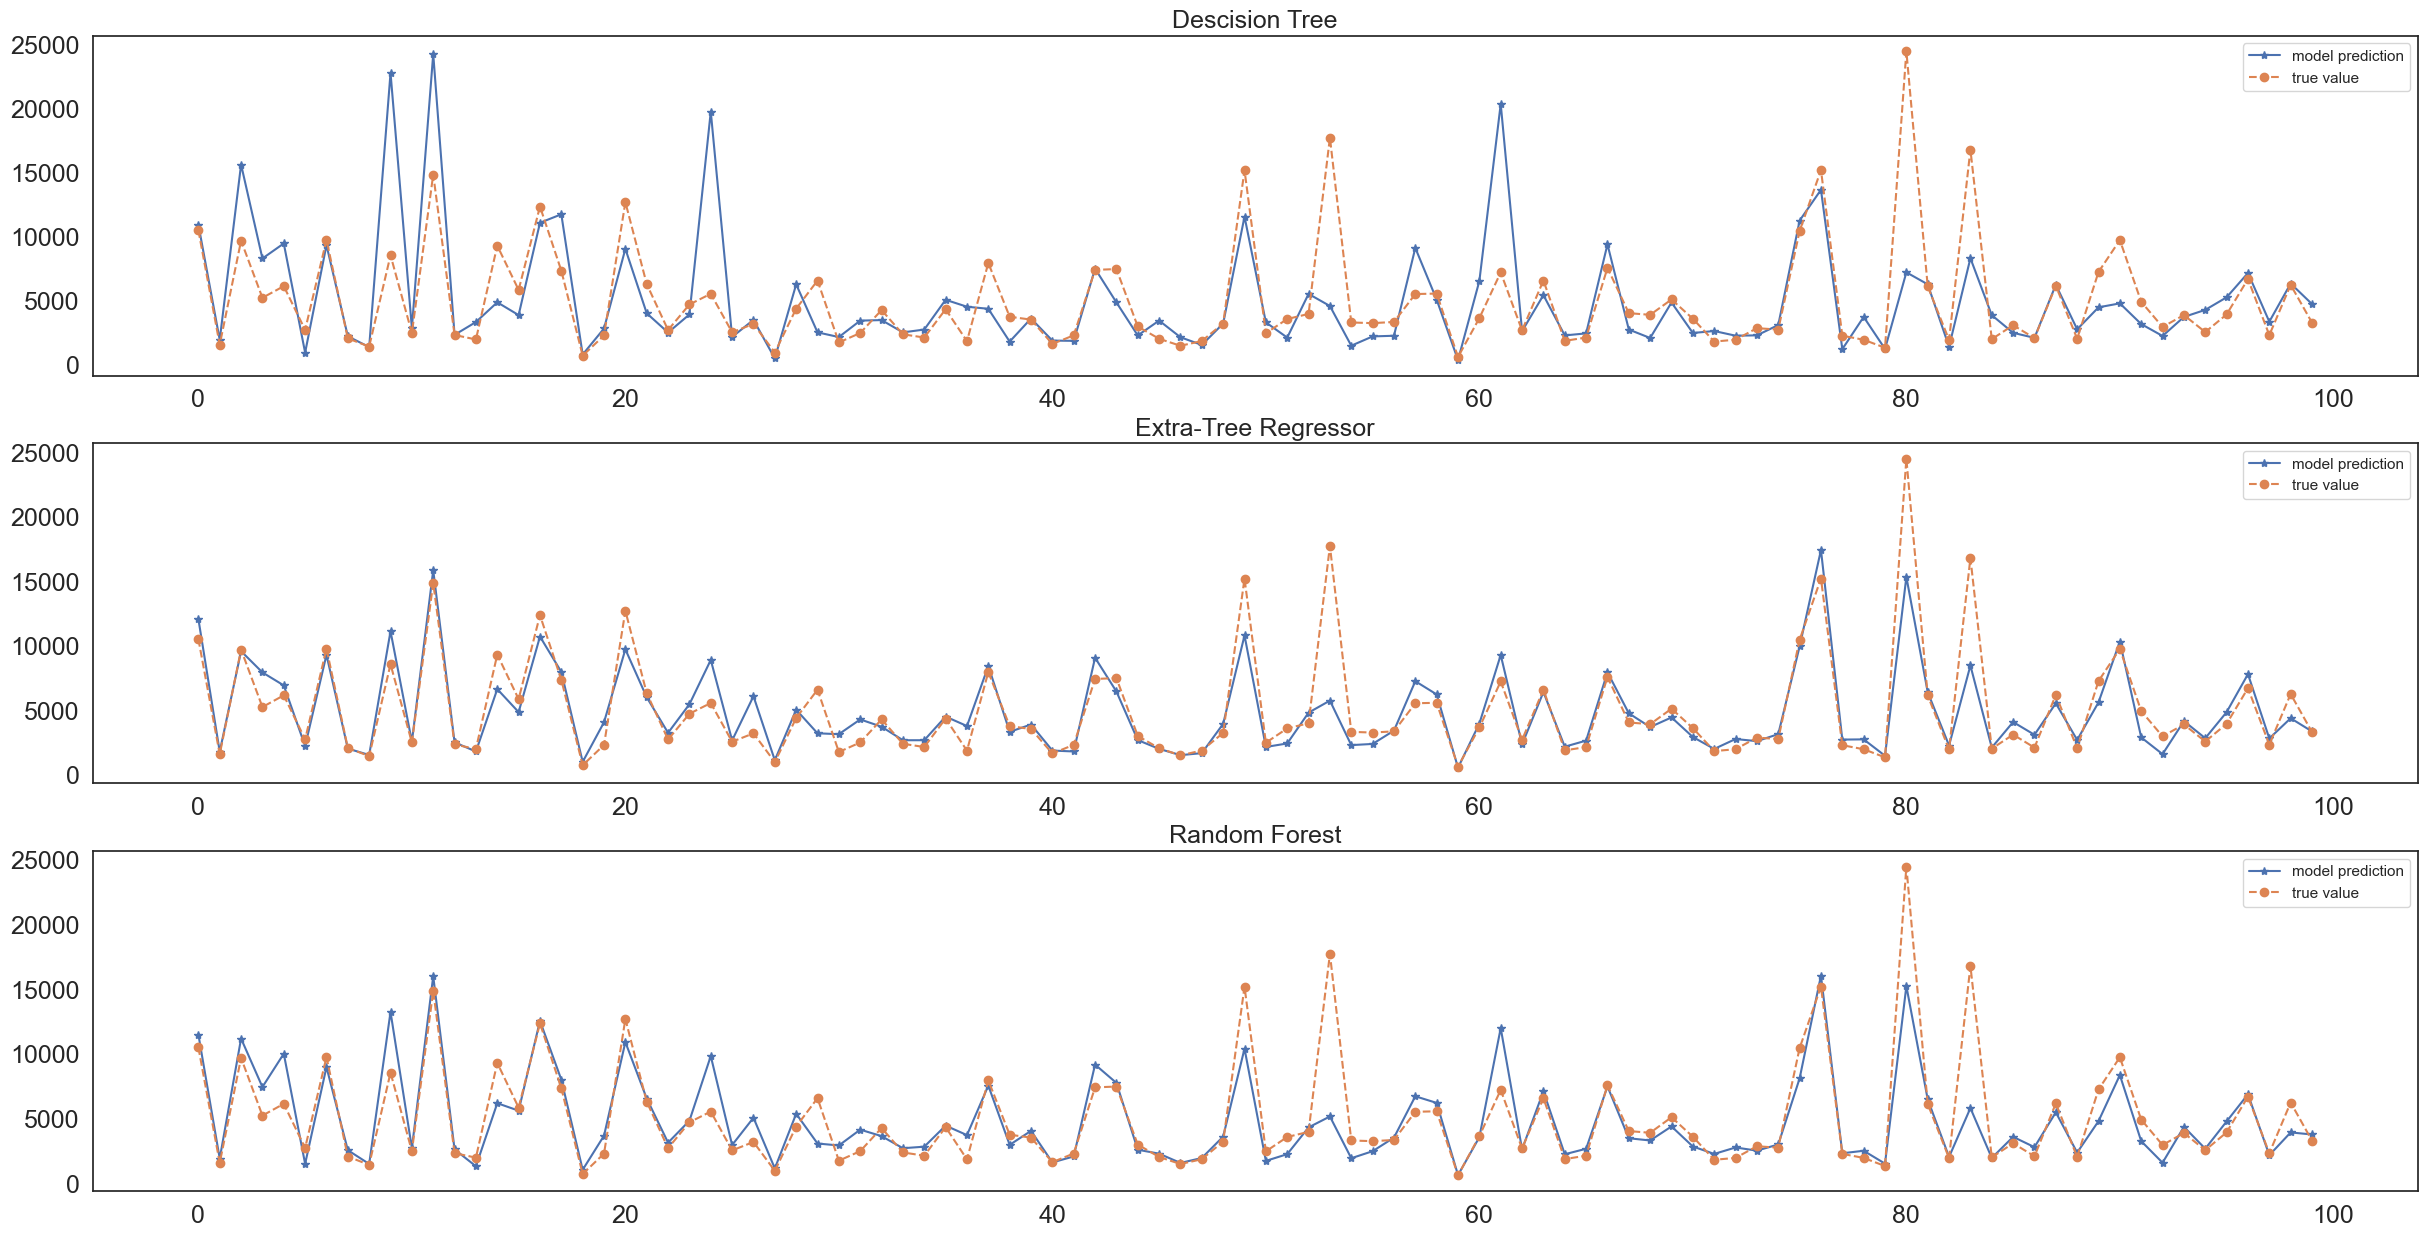

In [88]:
print_results(labels = ["Descision Tree:", "Extra-Tree Regressor:", "Random Forest:"],
             est = [dtr,etr, rfrr],
             plt_num = 100,
             testing = [tr_x_test, tr_y_test])

Linear Regression: 
R-Squared: -12,981,976,626.088
Root Mean Square Error: 81,282.494
Mean Absolute Error: 6,443.200



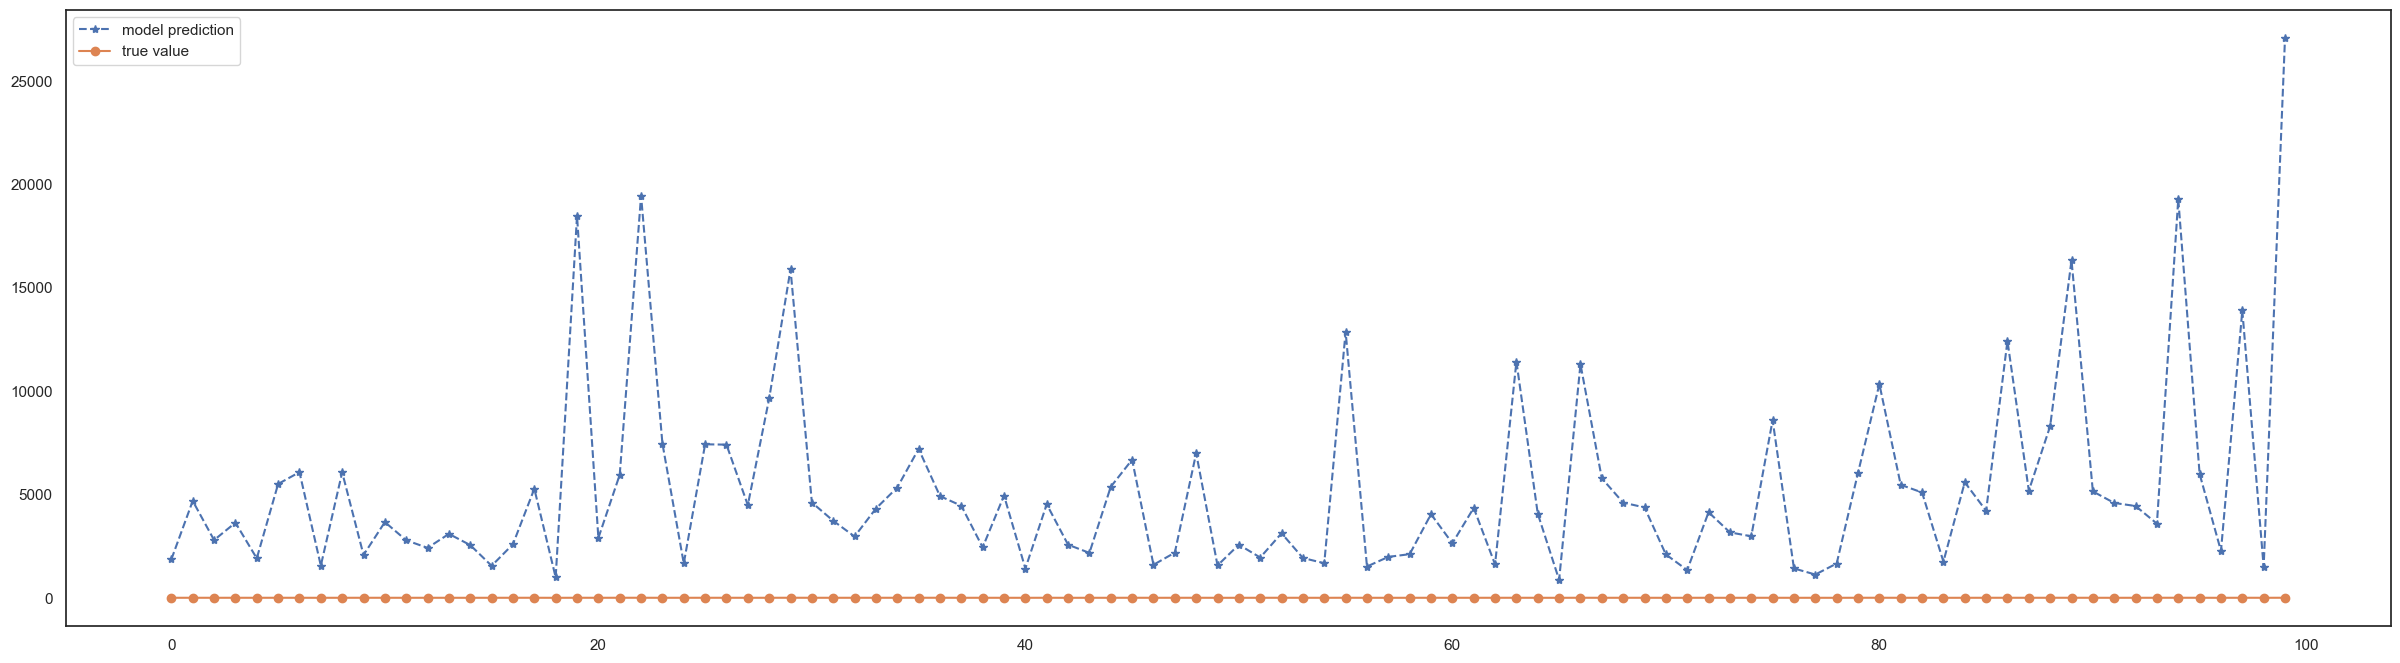

In [90]:
print("Linear Regression: ")

df_labels_prediction = lr.predict(lr_x_test_ppu)
df_labels_prediction =  np.exp(df_labels_prediction) * lr_y_test_ru

print("R-Squared: {:,.3f}".format(r2_score(lr_y_test, df_labels_prediction)))
mse = mean_squared_error(lr_y_test,df_labels_prediction) 
mae = mean_absolute_error(lr_y_test, df_labels_prediction)

rmse = np.sqrt(mse)
print("Root Mean Square Error: {:,.3f}".format(rmse))
print("Mean Absolute Error: {:,.3f}".format(mae))
print()

plt.rcParams["figure.figsize"] = (30,8)
plt.plot(range(100), df_labels_prediction[:100],"*--" ,label='model prediction')
plt.plot(range(100), lr_y_test[:100],"o-", label='true value')
plt.legend()

## Hyperparameter Tuning

In [109]:
# Random Search CV
grid_param = [{"etr__n_estimators": randint(low=20, high=60),
               "etr__max_features":randint(low=1, high=21)}]


random_SCV(etr,grid_param,n_iter = 5,cv = 20, file_name = "etr_test_1.pkl", training = [tr_x_train, tr_y_train])


Fitting 20 folds for each of 5 candidates, totalling 100 fits
[CV 1/20; 1/5] START etr__max_features=19, etr__n_estimators=46.................
[CV 1/20; 1/5] END etr__max_features=19, etr__n_estimators=46;, score=-0.095 total time=   5.6s
[CV 2/20; 1/5] START etr__max_features=19, etr__n_estimators=46.................
[CV 2/20; 1/5] END etr__max_features=19, etr__n_estimators=46;, score=-0.095 total time=   6.7s
[CV 3/20; 1/5] START etr__max_features=19, etr__n_estimators=46.................
[CV 3/20; 1/5] END etr__max_features=19, etr__n_estimators=46;, score=-0.092 total time=   7.2s
[CV 4/20; 1/5] START etr__max_features=19, etr__n_estimators=46.................
[CV 4/20; 1/5] END etr__max_features=19, etr__n_estimators=46;, score=-0.096 total time=   7.4s
[CV 5/20; 1/5] START etr__max_features=19, etr__n_estimators=46.................
[CV 5/20; 1/5] END etr__max_features=19, etr__n_estimators=46;, score=-0.112 total time=   5.6s
[CV 6/20; 1/5] START etr__max_features=19, etr__n_est

test1
R-Squared: 0.545
Root Mean Suqre Error: 4,853.416
Mean Absolute Error: 1,452.156



Pipeline(steps=[('etr',
                 BaggingRegressor(estimator=ExtraTreeRegressor(random_state=42),
                                  max_features=18, n_estimators=49,
                                  random_state=42))])

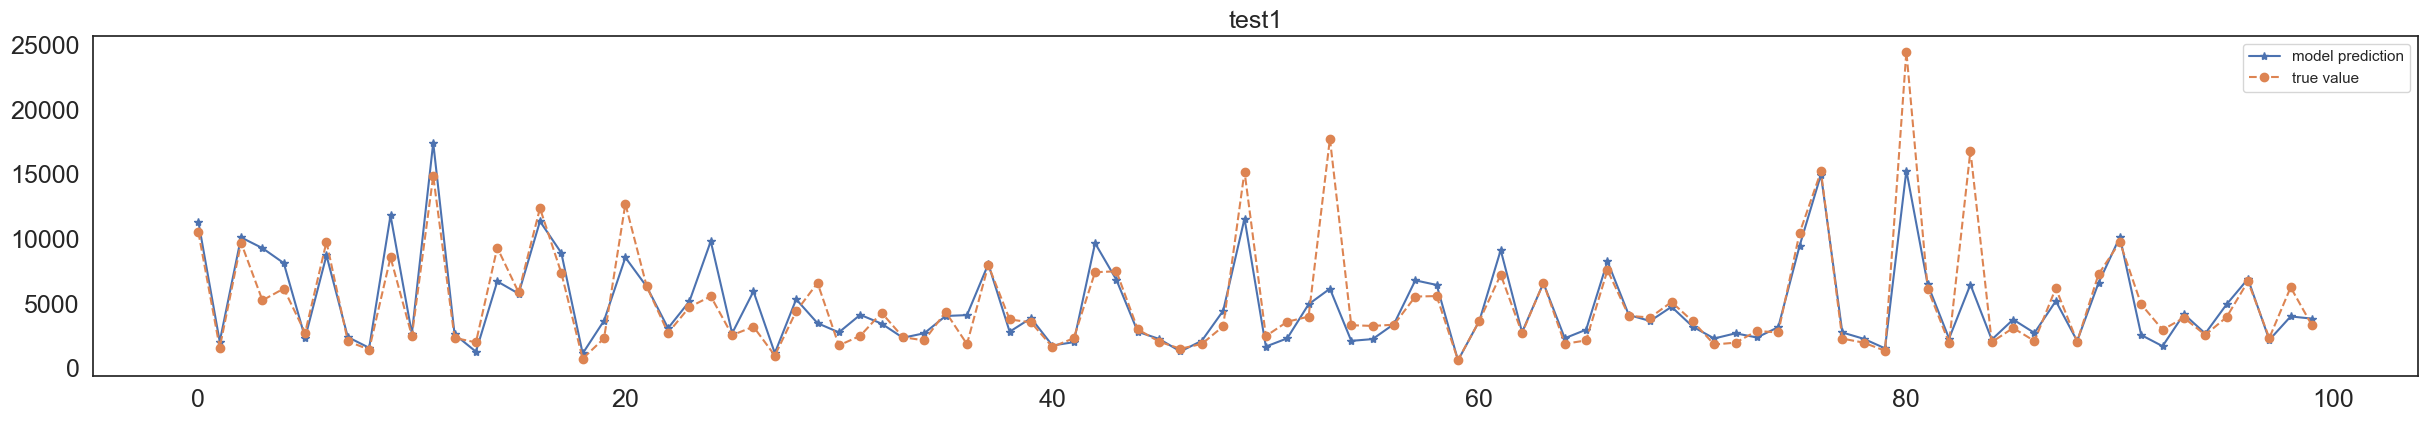

In [110]:
results = wr_pkl_file(file_name = "etr_test_1.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["test1"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
best_estimator

In [111]:
# Random Search CV
grid_param = [{"dtr__max_depth": randint(low=20, high=60),
               "dtr__min_samples_split": randint(low=2, high=6),
               "dtr__min_samples_leaf": randint(low=2, high=10)}]

random_SCV(dtr, grid_param, n_iter=5, cv=10, file_name="dt_test_1.pkl", training=[tr_x_train, tr_y_train])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START dtr__max_depth=20, dtr__min_samples_leaf=5, dtr__min_samples_split=3
[CV 1/10; 1/5] END dtr__max_depth=20, dtr__min_samples_leaf=5, dtr__min_samples_split=3;, score=-0.171 total time=   0.2s
[CV 2/10; 1/5] START dtr__max_depth=20, dtr__min_samples_leaf=5, dtr__min_samples_split=3
[CV 2/10; 1/5] END dtr__max_depth=20, dtr__min_samples_leaf=5, dtr__min_samples_split=3;, score=-0.173 total time=   0.2s
[CV 3/10; 1/5] START dtr__max_depth=20, dtr__min_samples_leaf=5, dtr__min_samples_split=3
[CV 3/10; 1/5] END dtr__max_depth=20, dtr__min_samples_leaf=5, dtr__min_samples_split=3;, score=-0.182 total time=   0.3s
[CV 4/10; 1/5] START dtr__max_depth=20, dtr__min_samples_leaf=5, dtr__min_samples_split=3
[CV 4/10; 1/5] END dtr__max_depth=20, dtr__min_samples_leaf=5, dtr__min_samples_split=3;, score=-0.174 total time=   0.3s
[CV 5/10; 1/5] START dtr__max_depth=20, dtr__min_samples_leaf=5, dtr__min_samples_split=3
[

Decision Tree Random Search CV
R-Squared: 0.483
Root Mean Suqre Error: 5,174.052
Mean Absolute Error: 1,861.516



Pipeline(steps=[('dtr',
                 DecisionTreeRegressor(max_depth=23, min_samples_leaf=8,
                                       min_samples_split=3))])

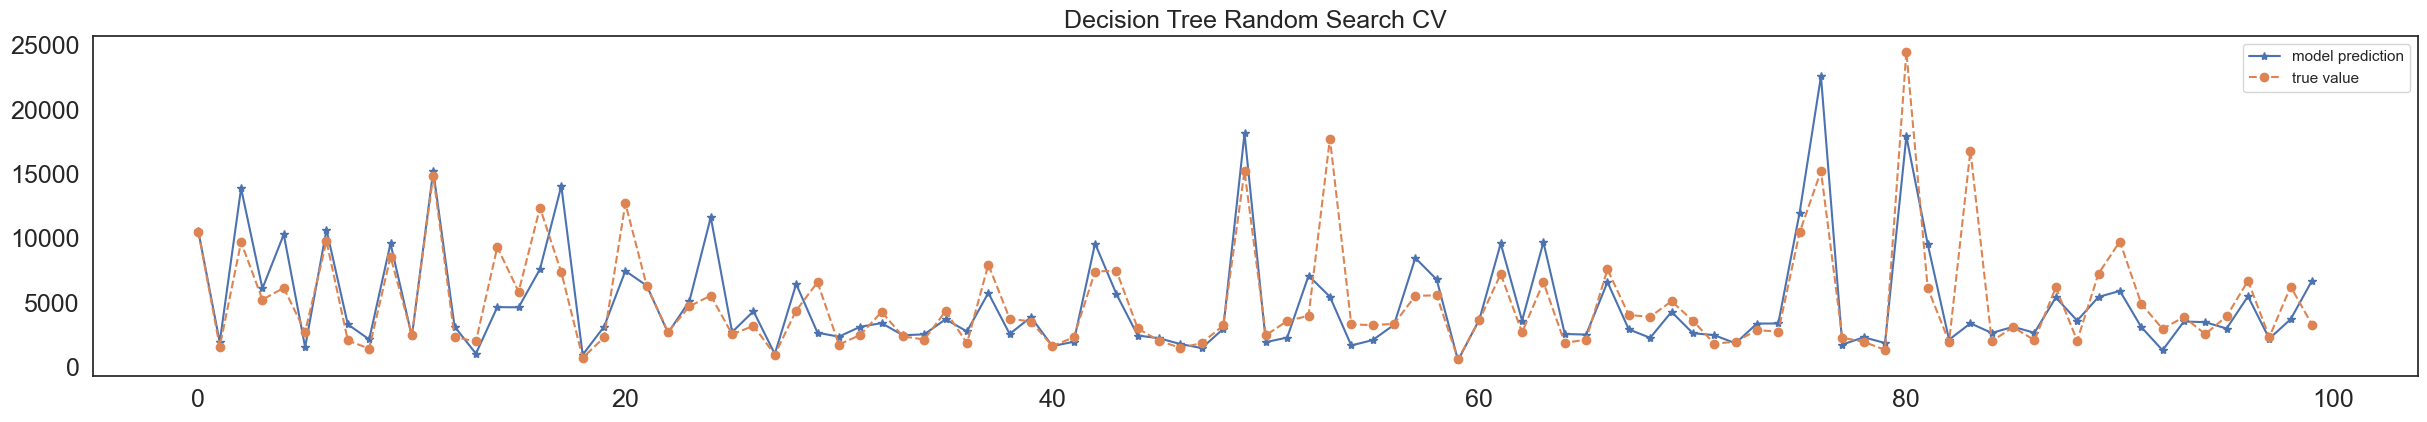

In [112]:
results = wr_pkl_file(file_name="dt_test_1.pkl", read=True)
best_estimator = results.best_estimator_

print_results(['Decision Tree Random Search CV'], best_estimator, testing=[tr_x_test, tr_y_test], plt_num=100)
best_estimator

In [113]:
# Random Search CV

grid_param = [{"rfregression__n_estimators": randint(low=20, high=100),
               "rfregression__min_samples_leaf":randint(low=2, high=30)}]


random_SCV(rfrr,grid_param,n_iter = 5,cv = 10, file_name = "rfr_test_2.pkl", training = [tr_x_train, tr_y_train])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START rfregression__min_samples_leaf=4, rfregression__n_estimators=29
[CV 1/10; 1/5] END rfregression__min_samples_leaf=4, rfregression__n_estimators=29;, score=-0.105 total time=   2.1s
[CV 2/10; 1/5] START rfregression__min_samples_leaf=4, rfregression__n_estimators=29
[CV 2/10; 1/5] END rfregression__min_samples_leaf=4, rfregression__n_estimators=29;, score=-0.103 total time=   1.7s
[CV 3/10; 1/5] START rfregression__min_samples_leaf=4, rfregression__n_estimators=29
[CV 3/10; 1/5] END rfregression__min_samples_leaf=4, rfregression__n_estimators=29;, score=-0.112 total time=   1.9s
[CV 4/10; 1/5] START rfregression__min_samples_leaf=4, rfregression__n_estimators=29
[CV 4/10; 1/5] END rfregression__min_samples_leaf=4, rfregression__n_estimators=29;, score=-0.104 total time=   1.9s
[CV 5/10; 1/5] START rfregression__min_samples_leaf=4, rfregression__n_estimators=29
[CV 5/10; 1/5] END rfregression__min_samples_l

Random Forest Random Search CV
R-Squared: 0.549
Root Mean Suqre Error: 4,831.911
Mean Absolute Error: 1,488.147



Pipeline(steps=[('rfregression',
                 RandomForestRegressor(min_samples_leaf=4, n_estimators=79,
                                       n_jobs=-1, random_state=42))])

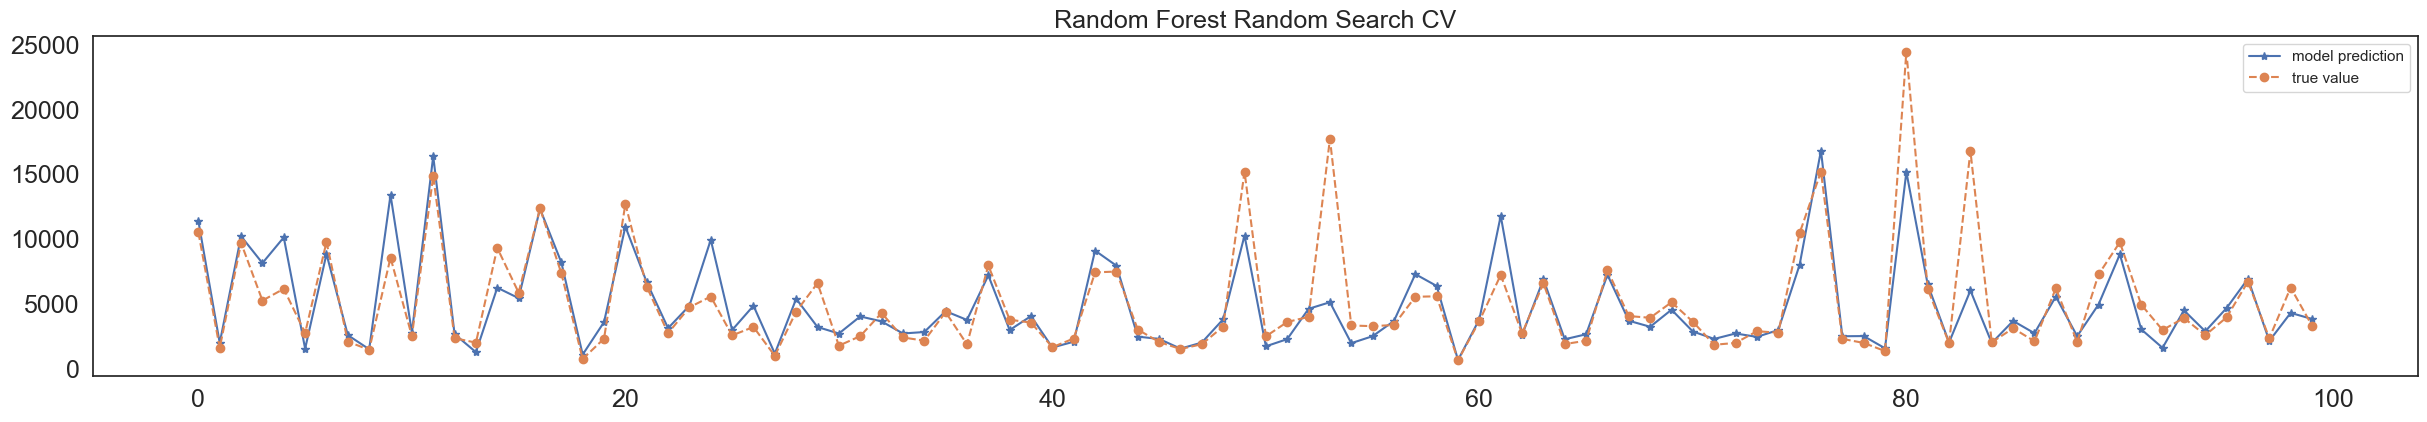

In [114]:
results = wr_pkl_file(file_name="rfr_test_2.pkl", read=True)
best_estimator = results.best_estimator_

print_results(['Random Forest Random Search CV'], best_estimator, testing=[tr_x_test, tr_y_test], plt_num=100)
best_estimator

In [115]:
# Grid Search CV
grid_param = [{"rfregression__n_estimators": [76,77,78],
               "rfregression__min_samples_leaf":[3]}]


grid_SCV(pipe = rfrr, grid_param = grid_param, 
         cv = 10, 
         scoring = 'neg_mean_squared_error', 
         file_name = "rfr_grid_test_2.pkl", training = [tr_x_train, tr_y_train])

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 1/10; 1/3] END rfregression__min_samples_leaf=3, rfregression__n_estimators=76;, score=-0.103 total time=   6.2s
[CV 2/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 2/10; 1/3] END rfregression__min_samples_leaf=3, rfregression__n_estimators=76;, score=-0.100 total time=   4.0s
[CV 3/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 3/10; 1/3] END rfregression__min_samples_leaf=3, rfregression__n_estimators=76;, score=-0.110 total time=   3.7s
[CV 4/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 4/10; 1/3] END rfregression__min_samples_leaf=3, rfregression__n_estimators=76;, score=-0.103 total time=   3.6s
[CV 5/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 5/10; 1/3] END rfregression__min_samples_l

Random Forest Grid Search CV
R-Squared: 0.556
Root Mean Suqre Error: 4,796.120
Mean Absolute Error: 1,483.672



{'rfregression__min_samples_leaf': 3, 'rfregression__n_estimators': 78}

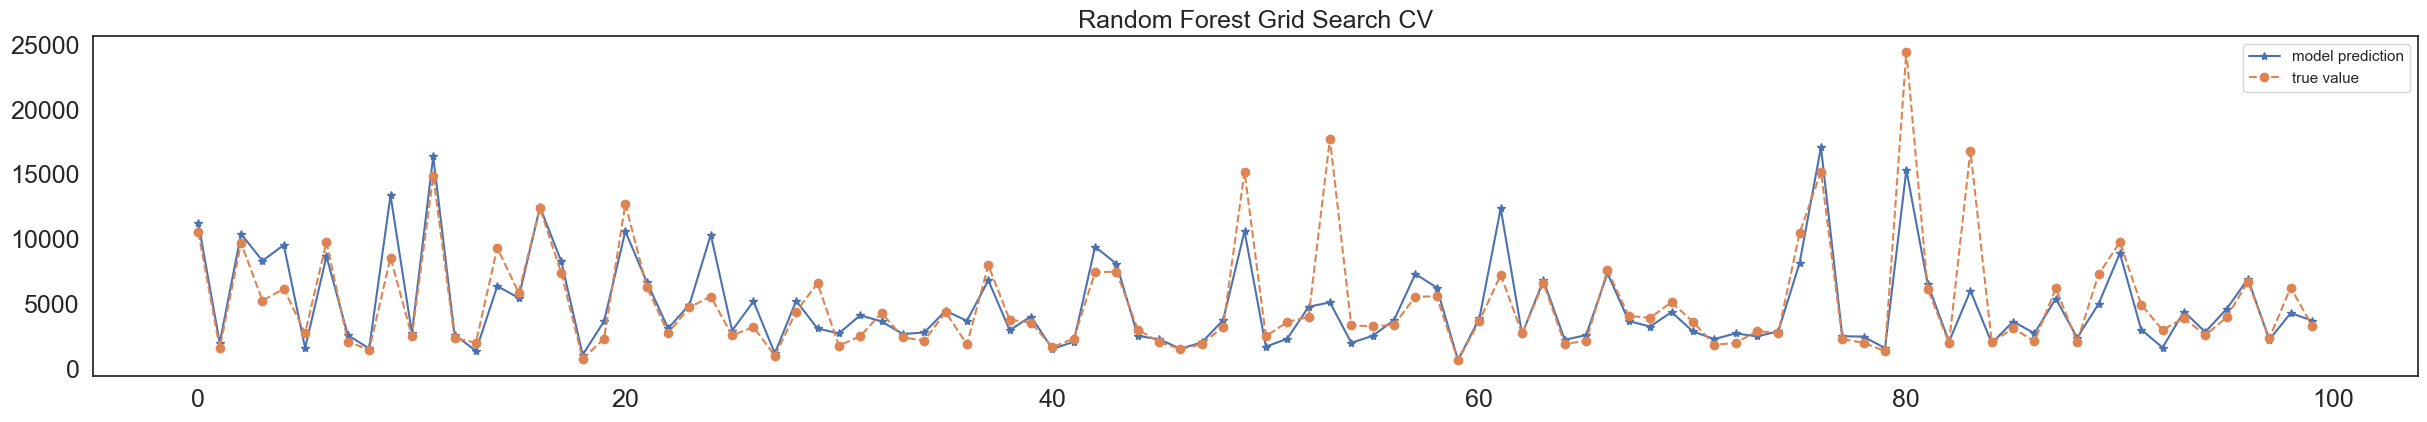

In [116]:
results = wr_pkl_file(file_name = "rfr_grid_test_2.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["Random Forest Grid Search CV"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
results.best_params_
